In [14]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

<h1> Butterworth Filters </h1>

In this notebook, we perform some calculations to learn about Butterworth filters, including my own implementations of some digital butterworth filters and comparing to other implementations in python standard libraries.

<h2> History </h2>

The Butterworth filter was originally published in a 1930 paper by the physicist Stephen Butterworth in an attempt to simplify the construction of electric filters, which up until that point was usually done as almost an art - components were selected carefully and changed out until the desired filter performance was achieved. 

The original paper itself is pretty readable by today's standards and I highly recommend just giving the original a read in you have the chance:
[On the Theory of Filter Amplifiers](https://www.changpuak.ch/electronics/downloads/On_the_Theory_of_Filter_Amplifiers.pdf)

In [105]:
class FilterTypes(Enum):
    LOWPASS = 1
    HIGHPASS = 2
    BANDPASS = 3
    BANDSTOP = 4
    

def plot_filter(filter_, min_freq, max_freq, n=1000, plot_phase=False, group_delay=False):
    """
    
    """
    f = np.logspace(np.log10(min_freq), np.log10(max_freq), n)
    response = filter_.frequency_response(f)
    fig1, ax1 = plt.subplots()
    ax1.semilogx(f, 20 * np.log10(abs(response)))
    ax1.set_title(f'Frequency response from {filter_}')
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Amplitude [dB]')
    ax1.margins(0, 0.1)
    ax1.grid(which='both', axis='both')
    fig1.show()

    if plot_phase:
        fig2, ax2 = plt.subplots()
        ax2.semilogx(f, np.unwrap(np.angle(response)*180.0/np.pi))
        ax2.set_title(f'Frequency response from {filter_}')
        ax2.set_xlabel('Frequency [Hz]')
        ax2.set_ylabel('phase [deg]')
    

class Filter():
        
    def __init__(self):
        raise NotImplementedError
        
    def frequency_response(self, f):
        """
        Frequency response of filter at particular frequency or set of frequencies
        """
        return self.f_resp(f)
        
    
    def fir(self, N, window):
        """
        Return FIR implementation of the filter
        """
        pass
    
    
class ButterworthFilter(Filter):

    def __init__(self, f_c, N, filter_type, bandwidth = None):
        """
        f_c: Cutoff frequency of filter . If filter type is Bandpass or Bandstop, this should
            be the center frequency of the filter
        N: Order of filter
        
        """
        assert filter_type in FilterTypes
        assert type(N) is int
        assert N > 0
        if filter_type in [FilterTypes.BANDPASS, FilterTypes.BANDSTOP]:
            assert bandwidth is not None
        self._fir = None
        self.N = N
        self.f_c = f_c
        
        # Note: this is definitely not an efficient implementation for quick evaluation. Howevwer, it is nice an pythonic
        if filter_type is FilterTypes.LOWPASS:
            self.poles = []
            for i in range(self.N):
                self.poles.append(self._get_pole(self.N, f_c, i))
    
    def f_resp(self, f):
        """
        f: np array
        """
        resp = np.ones(len(f))
        for i in range(self.N):
            resp = resp*self.poles[i](f)
        return resp
    
    def bilinear_mapping(self, N, i):
        pass
    
    def _get_one(self):
        
        def one(f):
            return f
        return one
    
    def _get_pole(self, N, f_c, i):
        """
        Returns N total equally spaced poles along the unit circle
        """
        phase_spacing = np.pi/N
        starting_phase = phase_spacing/2 + np.pi
        s_p = 1j*f_c*np.exp(1j*(starting_phase + phase_spacing*(i)))
        
        def pole(f):
            return -s_p/(1j*f - s_p)
        
        return pole
        
    def __repr__(self):
        return f'Order {self.N} Butterworth Filter, f_c = {self.f_c}'
        

    
class ChebyshevFilter(Filter):
    
    def __init__(self, filter_type, bandwidth=None):
        pass
        
    


<ipython-input-64-7635413215e1>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
<ipython-input-64-7635413215e1>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


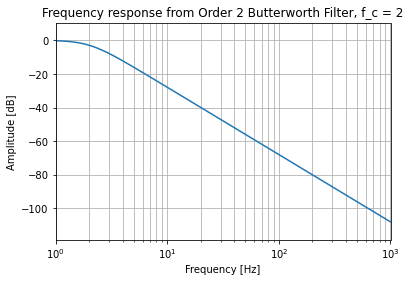

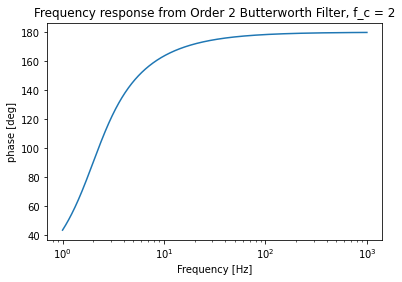

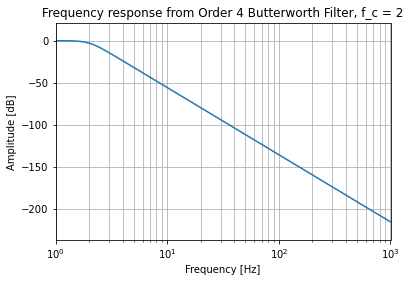

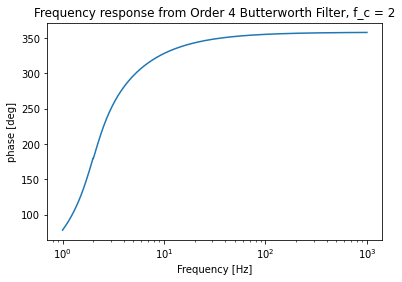

In [102]:
# Filter implemented as an FIR
N = 512  # Number of points in 
m = 4 # Order of filter
f_c = 2# Desired Cutoff frequency of filter 
f_s = 20 # sampling rate

f = np.linspace(-np.pi*1000, np.pi*1000, N)

b = ButterworthFilter(f_c, 2, FilterTypes.LOWPASS)
plot_filter(b, 1, 1000, plot_phase=True)
c = ButterworthFilter(f_c, 4, FilterTypes.LOWPASS)
plot_filter(c, 1, 1000, plot_phase=True)



In [103]:
f = np.linspace(0, np.pi*100, N)
c = np.fft.ifft(b.f_resp(f))

c:\users\aaron\code\venv37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


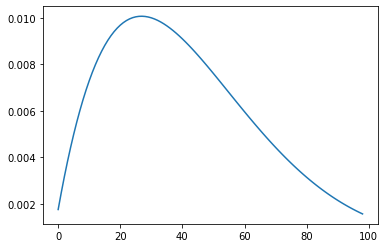

In [104]:
plt.plot(c[-1:-100:-1])

In [55]:
resp = np.ones(len(f))
for i in range(2):
    resp = resp*poles[i](f)

In [56]:
resp

array([0.98990101+0.14140722j, 0.95846645+0.28239089j])

<function numpy.fft.ifft(a, n=None, axis=-1, norm=None)>